# Setting

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import datetime as dt

import gurobipy as gp
from gurobipy import GRB

from gmplot import gmplot
import requests
import polyline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
api_key = 'api_key'

# location of depot
depot_lat = 51.327580
depot_lng = -2.606940

# adjustment for large size vehicle
large_coef = 1.05

# average service time (mins)
svc = 32.9

# Large constant
# Constant
M = 10000
sn = 0.000001

In [3]:
df = pd.read_csv('data_raw.csv')

# Pre-processing

## Node sets

In [4]:
order_cnt = int(len(df)/2)

# all nodes including depot
n = [i for i in range(len(df)+2)]

# all pickup points
p_plus = [i for i in range(1, order_cnt+1)]

# all delivery points
p_minus = [i for i in range(order_cnt+1, order_cnt*2+1)]

# set of pickup and delivery points
p = [i for i in range(1, len(df)+1)]

# all departing points
n_plus = [i for i in range(len(df)+1)]

# all arrival points
n_minus = [i for i in range(1, len(df)+2)]

## Travel distance / Travel time

### Time data type transform

In [5]:
df['CUSTOMER_TIMESLOT_START'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_START'])
df['CUSTOMER_TIMESLOT_END'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_END'])

df['START_TIME'] = pd.to_datetime(df['START_TIME'])
df['END_TIME'] = pd.to_datetime(df['END_TIME'])

df['tw_start_mins'] = df['CUSTOMER_TIMESLOT_START'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_START'].dt.minute
df['tw_end_mins'] = df['CUSTOMER_TIMESLOT_END'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_END'].dt.minute

# calculate accurate time in minutes
df['real_start_mins'] = (df['START_TIME'].dt.hour * 60*60 + df['START_TIME'].dt.minute *60 + df['START_TIME'].dt.second)/60
df['real_end_mins'] = (df['END_TIME'].dt.hour * 60*60 + df['END_TIME'].dt.minute*60 + df['END_TIME'].dt.second)/60

In [6]:
# depends on the data date
today = pd.to_datetime('2023-09-15')

# if the start data is the previous date then repplace with 0
df.loc[df['CUSTOMER_TIMESLOT_START'].dt.date < today, 'tw_start_mins'] = 0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


### Extract location data

In [7]:
dist = df[['LAT', 'LNG', 'ORDER_INDEX']]

# set depot
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':0}, ignore_index=True)
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':11}, ignore_index=True)

dist = dist.sort_values('ORDER_INDEX')
dist = dist.reset_index(drop=True)

### Large size vehicle speed adjustment

#### Calculate the real travel time

In [3]:
# # sort by sequence to calculate the real travel time between nodes
# df = df.sort_values('SORT_ORDER').reset_index()

# df['real_travel_time'] = 0.00

# for i in range(1, len(df)):
#     df['real_travel_time'][i] = df['real_start_mins'][i] - df['real_end_mins'][i-1]

#### Calculate the travel time from google map API

In [9]:
# def google_maps_driving_time(lat1, lon1, lat2, lon2, api_key, vehicle_type='small'):
#     origin = f"{lat1},{lon1}"
#     destination = f"{lat2},{lon2}"
#     # large_coef = 1.18   # the time of the truck is around 1.18 times of that of passenger car
    
#     # API request URL
#     url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&mode=driving&departure_time=now&key={api_key}"
    
#     # request
#     response = requests.get(url)
#     result = response.json()
    
#     if result['status'] == 'OK':
#         # get travel distance
#         distance_meters = result['rows'][0]['elements'][0]['distance']['value']
#         distance_km = distance_meters / 1000.0

#         # get travel time
#         driving_time_seconds = result['rows'][0]['elements'][0]['duration']['value']
#         # adjust the time according to vehicle type
#         # if vehicle_type == 'large':
#         #     driving_time_seconds *= large_coef
#         # convert the unit to minintes
#         driving_time_minutes = driving_time_seconds / 60.0
        
#         return distance_km, driving_time_minutes
#     else:
#         raise Exception(f"Error fetching driving time from Google Maps API: {result['status']} - {result.get('error_message', '')}")


In [10]:
# time_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])

# for i in range(len(dist)):
#     for j in range(len(dist)):
#         if i != j:
#             time_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[1]

#### Calculate the large-size vehicle travel time ratio

In [2]:
# df['gmap_time'] = 0.00

# for i in range(1, len(df)):
#     df['gmap_time'][i] = time_matrix[df['ORDER_INDEX'][i]][df['ORDER_INDEX'][i-1]]

In [1]:
# df['ratio'] = df['real_travel_time'] / df['gmap_time']
# df['ratio'].mean()

### Finalised travel distance / travel time

In [11]:
def google_maps_driving_time(lat1, lon1, lat2, lon2, api_key, vehicle_type='small'):
    origin = f"{lat1},{lon1}"
    destination = f"{lat2},{lon2}"

    # API request URL
    url = f"https://maps.googleapis.com/maps/api/distancematrix/json?origins={origin}&destinations={destination}&mode=driving&departure_time=now&key={api_key}"
    
    # request
    response = requests.get(url)
    result = response.json()
    
    if result['status'] == 'OK':
        # get travel distance
        distance_meters = result['rows'][0]['elements'][0]['distance']['value']
        distance_km = distance_meters / 1000.0

        # get travel time
        driving_time_seconds = result['rows'][0]['elements'][0]['duration']['value']
        # adjust the time according to vehicle type
        if vehicle_type == 'large':
            driving_time_seconds *= large_coef
        # convert the unit to minintes
        driving_time_minutes = driving_time_seconds / 60.0
        
        return distance_km, driving_time_minutes
    else:
        raise Exception(f"Error fetching driving time from Google Maps API: {result['status']} - {result.get('error_message', '')}")


In [12]:
dist_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])
time_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])

for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            dist_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[0]
            time_matrix.loc[i, j] = google_maps_driving_time(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j], api_key, vehicle_type='large')[1]

In [13]:
dist_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,36.39,21.133,21.778,25.101,20.938,29.027,22.465,22.21,26.246,30.398,0.0
1.0,36.389,NaN,20.079,37.807,6.721,11.125,7.375,22.518,22.008,7.887,35.038,36.389
2.0,21.208,20.468,NaN,23.529,19.904,15.741,30.193,1.472,1.217,15.262,20.76,21.208
3.0,21.777,38.221,23.505,NaN,41.977,35.754,47.947,22.816,22.306,33.016,7.322,21.777
4.0,25.103,6.08,23.97,40.985,NaN,4.991,3.722,25.697,25.186,7.162,38.929,25.103
5.0,22.096,11.184,13.34,38.945,5.042,NaN,11.056,15.779,15.268,7.862,36.176,22.096
6.0,28.136,7.569,29.36,47.087,3.734,8.912,NaN,31.798,31.288,10.084,44.318,28.136
7.0,22.521,22.911,1.453,22.823,21.39,17.227,32.637,NaN,0.51,17.706,20.054,22.521
8.0,22.267,22.401,1.199,22.312,20.879,16.716,32.126,0.51,NaN,17.195,19.543,22.267
9.0,27.286,7.995,16.838,34.565,7.811,7.821,18.12,19.277,18.767,NaN,31.797,27.286


In [14]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,50.0487,31.3937,31.589133,44.523267,34.076467,43.563867,34.129767,32.9927,40.3481,41.058767,0.0
1.0,50.777133,NaN,26.347967,36.4039,13.4849,21.977367,15.492533,29.066267,27.485033,16.931633,32.015533,50.777133
2.0,31.109433,26.4368,NaN,29.759167,32.370867,21.9063,32.388633,4.228467,3.109167,24.8378,25.3708,31.109433
3.0,31.731267,36.155167,29.297233,NaN,42.4801,40.8278,42.089233,28.177933,26.578933,34.5384,13.7514,31.731267
4.0,45.6248,13.5915,33.5257,41.964867,NaN,13.5382,8.972167,34.627233,34.662767,17.3225,39.193267,45.6248
5.0,34.2186,22.208333,22.883467,41.6273,13.449367,NaN,18.637233,25.601767,24.020533,16.274267,37.238933,34.2186
6.0,43.190767,15.385933,30.842933,40.8811,8.4214,21.515433,NaN,33.561233,31.962233,22.101733,36.5105,43.190767
7.0,34.023167,28.853067,4.015267,28.284533,35.2313,24.766733,34.8049,NaN,1.634533,27.254067,23.896167,34.023167
8.0,32.7262,27.218533,2.700533,26.65,33.596767,23.1322,33.170367,1.581233,NaN,25.619533,22.261633,32.7262
9.0,40.703433,17.020467,26.898733,36.954667,18.3352,16.167667,24.908867,29.617033,28.0358,NaN,32.5663,40.703433


## Time window

In [15]:
tw = df[['tw_start_mins', 'tw_end_mins', 'ORDER_INDEX']]
tw.rename(columns={'tw_start_mins':'a', 'tw_end_mins':'b'}, inplace=True)

# set depot
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':0}, ignore_index=True)
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':11}, ignore_index=True)

tw = tw.sort_values('ORDER_INDEX')
tw = tw.reset_index(drop=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
tw

,a,b,ORDER_INDEX
0,0,1379,0
1,600,960,1
2,540,840,2
3,840,900,3
4,420,480,4
5,420,600,5
6,0,1379,6
7,0,1379,7
8,0,1379,8
9,0,1379,9


# Model1: Min-max

## Model

In [ ]:
# model
m1 = gp.Model("Min_Z")
m1.params.NonConvex = 2    # non-convex constraints

# Variables
x = m1.addVars(n, n, vtype=GRB.BINARY, name='x')
z = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')
ta = m1.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = m1.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service
late = m1.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')
sum_late = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name='sum_late')
total_penalty = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')
total_duration = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_duration')

da = m1.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='da')  # actural duration
di = m1.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='di')  # ideal duration

# Variables for penalty function
penalty_coeff = m1.addVars(p, name="penalty_coeff")
is_0_30 = m1.addVars(p, vtype=GRB.BINARY, name="is_0_30")
is_30_60 = m1.addVars(p, vtype=GRB.BINARY, name="is_30_60")
is_60_120 = m1.addVars(p, vtype=GRB.BINARY, name="is_60_120")
is_120_180 = m1.addVars(p, vtype=GRB.BINARY, name="is_120_180")
is_180_240 = m1.addVars(p, vtype=GRB.BINARY, name="is_180_240")
is_above_240 = m1.addVars(p, vtype=GRB.BINARY, name="is_above_240")

# Objective
m1.ModelSense = GRB.MINIMIZE
m1.setObjectiveN(z, 0, 1)
m1.setObjectiveN(total_dist, 1, 0)

# Constraints
m1.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))


# penalty function: piecewise linear
m1.addConstrs((late[i] >= 0 + sn - M * (1 - is_0_30[i]) for i in p), name="p_0_30")
m1.addConstrs((late[i] <= 30 + M * (1 - is_0_30[i]) for i in p), name="p_0_30")

# all constraints must be either non-strict inequality constraints, either >= or =
m1.addConstrs((late[i] >= 30 + sn - M * (1 - is_30_60[i]) for i in p), name="p_30_60")
m1.addConstrs((late[i] <= 60 + M * (1 - is_30_60[i]) for i in p), name="p_30_60")

m1.addConstrs((late[i] >= 60 + sn - M * (1 - is_60_120[i]) for i in p), name="p_60_120")
m1.addConstrs((late[i] <= 120 + M * (1 - is_60_120[i]) for i in p), name="p_60_120")

m1.addConstrs((late[i] >= 120 + sn - M * (1 - is_120_180[i]) for i in p), name="p_120_180")
m1.addConstrs((late[i] <= 180 + M * (1 - is_120_180[i]) for i in p), name="p_120_180")

m1.addConstrs((late[i] >= 180 + sn - M * (1 - is_180_240[i]) for i in p), name="p_180_240")
m1.addConstrs((late[i] <= 240 + M * (1 - is_180_240[i]) for i in p), name="p_180_240")

m1.addConstrs((late[i] >= 240 + sn - M * (1 - is_above_240[i]) for i in p), name="p_over_240")

# ensure assigned to one of the category
m1.addConstrs(is_0_30[i]+is_30_60[i]+is_60_120[i]+is_120_180[i]+is_180_240[i]+is_above_240[i] == 1 for i in p)

m1.addConstrs((penalty_coeff[i] == 0.1 * is_0_30[i] + 
                                   0.2 * is_30_60[i] + 
                                   0.4 * is_60_120[i] + 
                                   0.7 * is_120_180[i] +
                                   1.1 * is_180_240[i] +
                                   1.7 * is_above_240[i] for i in p), name="penalty_coeff")

m1.addConstr(total_penalty == gp.quicksum(penalty_coeff[i] * late[i] for i in p))
m1.addConstr(sum_late == gp.quicksum(late[i] for i in p))


m1.addConstrs((z >= late[i] + late[i+order_cnt] + total_penalty for i in p_plus), name='eq3')

m1.addConstr((total_duration == ta[len(n)-1] - ts[0]))
m1.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq4')

m1.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq5')
m1.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq6')

m1.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq7')
m1.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq8')

m1.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq9')
m1.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq10')

m1.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq11')

m1.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')
m1.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')

m1.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq13')
m1.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq13')

m1.addConstrs((ts[j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq19')
m1.addConstrs((ts[j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq19')

m1.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq14')

m1.addConstrs((da[i] == ta[i + order_cnt] - ts[i] for i in p_plus), name='eq15')
m1.addConstrs((di[i] == time_matrix[i][i + order_cnt] + svc for i in p_plus), name='eq16')


# solve
m1.optimize()

if m1.status == GRB.Status.OPTIMAL:
    print("Optimal solution found")
else:
    print("No optimal solution found.")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 409 rows, 265 columns and 1439 nonzeros
Model fingerprint: 0xe61d6174
Model has 1 quadratic constraint
Model has 10 general constraints
Variable types: 61 continuous, 204 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
-----------------------------------------------------------

## Results

### The optimal route

In [18]:
if m1.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


### Results for each point

In [21]:
ta_values = [ta[i].X for i in best_route]
ts_values = [ts[i].X for i in best_route]
late_values = [late[i].X for i in best_route]


result_df = pd.DataFrame({
    "Point": best_route,
    "ta": ta_values,
    "ts": ts_values,
    "late": late_values
})

In [22]:
result_df

,Point,ta,ts,late
0,0,0.000000,0.000000,0.000000e+00
1,5,34.218600,420.000000,0.000000e+00
2,4,463.538200,463.538200,0.000000e+00
3,1,507.023100,600.000000,0.000000e+00
4,6,645.385933,645.385933,0.000000e+00
5,9,700.294800,700.294800,0.000000e+00
6,2,755.132600,755.132600,0.000000e+00
7,10,809.774967,809.774967,8.334167e-07
8,3,853.526367,853.526367,0.000000e+00
9,8,910.176367,910.176367,0.000000e+00


In [19]:
print(f'Total distance: {total_dist.X}')

Total distance: 102.85700000000001


## Visualisation

### optimal result

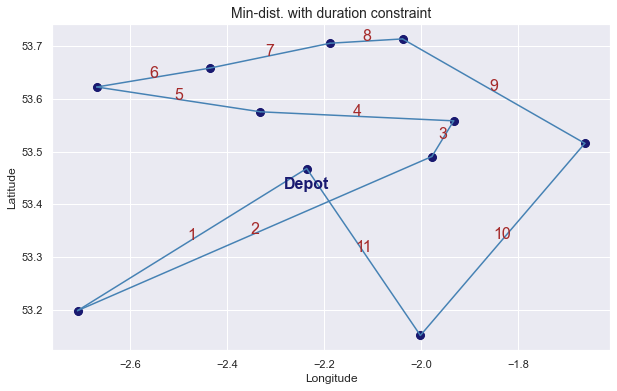

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='midnightblue')


# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'steelblue')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=16, color='brown')

plt.annotate('Depot', (dist['LNG'][0], dist['LAT'][0]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=16, color='midnightblue', weight='bold')

plt.title('Optimal Route Visualization', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Original result

In [59]:
ori_route = [0, 5, 4, 9, 2, 7, 3, 10, 8, 1, 6, 11]

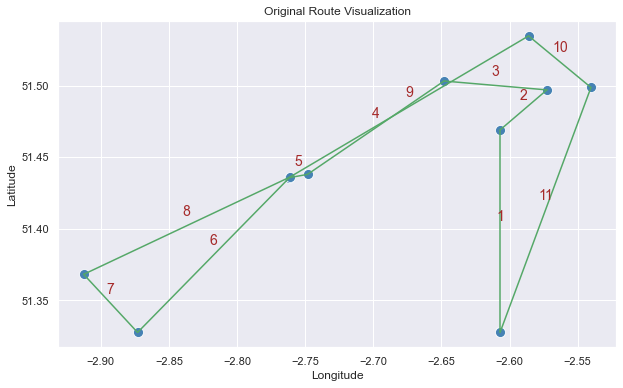

In [60]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')


# Plotting the route
for i in range(len(ori_route) - 1):
    start_point = ori_route[i]
    end_point = ori_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'g-')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=14, color='brown')



plt.title('Original Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Results on Google map

In [157]:
file_name = 'optimized_route_map_gmap.html'

In [158]:
latitude_list = dist['LAT'].tolist()
longitude_list = dist['LNG'].tolist()

best_route_latitudes = [latitude_list[i] for i in best_route]
best_route_longitudes = [longitude_list[i] for i in best_route]

# setting size
gmap = gmplot.GoogleMapPlotter(51.45, -2.60, 10, apikey=api_key)

# plot all points
gmap.scatter(latitude_list, longitude_list, 'lightcoral', size=40, marker=True)

# travelling path on google map
for idx in range(len(best_route) - 1):
    start = f"{latitude_list[best_route[idx]]},{longitude_list[best_route[idx]]}"
    end = f"{latitude_list[best_route[idx + 1]]},{longitude_list[best_route[idx + 1]]}"
    url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start}&destination={end}&key={api_key}"
    
    response = requests.get(url)
    directions = response.json()
    
    # ensure request successful
    if directions['status'] == 'OK':
        route = directions['routes'][0]['overview_polyline']['points']
        decoded_route = polyline.decode(route)
        latitudes, longitudes = zip(*decoded_route)
        gmap.plot(latitudes, longitudes, 'blue', edge_width=4)
    else:
        print(f"Error fetching directions between {start} and {end}: {directions['status']}")

# save the map
gmap.draw(file_name)

# Model2: Min-sum

## Model

In [ ]:
# model
m2 = gp.Model("Min_sum")
m2.params.NonConvex = 2    # non-convex constraints

# Variables
x = m2.addVars(n, n, vtype=GRB.BINARY, name='x')
z = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')
ta = m2.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = m2.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service
late = m2.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')
sum_late = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name='sum_late')
total_penalty = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')
total_duration = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_duration')

da = m2.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='da')  # actural duration
di = m2.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='di')  # ideal duration


# Variables for penalty function
penalty_coeff = m2.addVars(p, name="penalty_coeff")
is_0_30 = m2.addVars(p, vtype=GRB.BINARY, name="is_0_30")
is_30_60 = m2.addVars(p, vtype=GRB.BINARY, name="is_30_60")
is_60_120 = m2.addVars(p, vtype=GRB.BINARY, name="is_60_120")
is_120_180 = m2.addVars(p, vtype=GRB.BINARY, name="is_120_180")
is_180_240 = m2.addVars(p, vtype=GRB.BINARY, name="is_180_240")
is_above_240 = m2.addVars(p, vtype=GRB.BINARY, name="is_above_240")


# Objective
m2.ModelSense = GRB.MINIMIZE
m2.setObjectiveN(z, 0, 1)
m2.setObjectiveN(total_dist, 1, 0)

# Constraints
m2.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))

# penalty function: piecewise linear
m2.addConstrs((late[i] >= 0 + sn - M * (1 - is_0_30[i]) for i in p), name="p_0_30")
m2.addConstrs((late[i] <= 30 + M * (1 - is_0_30[i]) for i in p), name="p_0_30")

m2.addConstrs((late[i] >= 30 + sn - M * (1 - is_30_60[i]) for i in p), name="p_30_60")
m2.addConstrs((late[i] <= 60 + M * (1 - is_30_60[i]) for i in p), name="p_30_60")

m2.addConstrs((late[i] >= 60 + sn - M * (1 - is_60_120[i]) for i in p), name="p_60_120")
m2.addConstrs((late[i] <= 120 + M * (1 - is_60_120[i]) for i in p), name="p_60_120")

m2.addConstrs((late[i] >= 120 + sn - M * (1 - is_120_180[i]) for i in p), name="p_120_180")
m2.addConstrs((late[i] <= 180 + M * (1 - is_120_180[i]) for i in p), name="p_120_180")

m2.addConstrs((late[i] >= 180 + sn - M * (1 - is_180_240[i]) for i in p), name="p_180_240")
m2.addConstrs((late[i] <= 240 + M * (1 - is_180_240[i]) for i in p), name="p_180_240")

m2.addConstrs((late[i] >= 240 + sn - M * (1 - is_above_240[i]) for i in p), name="p_over_240")

m2.addConstrs(is_0_30[i]+is_30_60[i]+is_60_120[i]+is_120_180[i]+is_180_240[i]+is_above_240[i] == 1 for i in p)

m2.addConstrs((penalty_coeff[i] == 0.1 * is_0_30[i] + 
                                   0.2 * is_30_60[i] + 
                                   0.4 * is_60_120[i] + 
                                   0.7 * is_120_180[i] +
                                   1.1 * is_180_240[i] +
                                   1.7 * is_above_240[i] for i in p), name="penalty_coeff")

m2.addConstr(total_penalty == gp.quicksum(penalty_coeff[i] * late[i] for i in p))

m2.addConstr(sum_late == gp.quicksum(late[i] for i in p))
m2.addConstr((z >= sum_late + total_penalty), name='eq3')

m2.addConstr((total_duration == ta[len(n)-1] - ts[0]))

m2.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq4')

m2.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq5')
m2.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq6')

m2.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq7')
m2.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq8')

m2.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq9')
m2.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq10')

m2.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq11')

m2.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')
m2.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')

m2.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq13')
m2.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq13')

m2.addConstrs((ts[j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq19')
m2.addConstrs((ts[j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq19')

m2.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq14')

m2.addConstrs((da[i] == ta[i + order_cnt] - ts[i] for i in p_plus), name='eq15')
m2.addConstrs((di[i] == time_matrix[i][i + order_cnt] + svc for i in p_plus), name='eq16')

# solve
m2.optimize()

if m2.status == GRB.Status.OPTIMAL:
    print("Optimal solution found")
else:
    print("No optimal solution found.")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 405 rows, 265 columns and 1422 nonzeros
Model fingerprint: 0xac8e61e1
Model has 1 quadratic constraint
Model has 10 general constraints
Variable types: 61 continuous, 204 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
-----------------------------------------------------------

## Results

### The optimal route

In [25]:
if m2.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 5, 4, 1, 6, 9, 2, 10, 3, 8, 7, 11]


### Results for each point

In [ ]:
ta_values = [ta[i].X for i in best_route]
ts_values = [ts[i].X for i in best_route]
late_values = [late[i].X for i in best_route]


result_df = pd.DataFrame({
    "Point": best_route,
    "ta": ta_values,
    "ts": ts_values,
    "late": late_values
})

In [ ]:
result_df

,Point,ta,ts,late
0,0,0.000000,0.000000,0.000000e+00
1,5,34.218600,420.000000,0.000000e+00
2,4,463.538200,463.538200,0.000000e+00
3,1,507.023100,600.000000,0.000000e+00
4,6,645.385933,645.385933,0.000000e+00
5,9,700.294800,700.294800,0.000000e+00
6,2,755.132600,755.132600,0.000000e+00
7,10,809.774967,809.774967,8.334167e-07
8,3,853.526367,853.526367,0.000000e+00
9,8,910.176367,910.176367,0.000000e+00


In [26]:
print(f'Total distance: {total_dist.X}')

Total distance: 102.85700000000001


## Visualisation

### optimal result

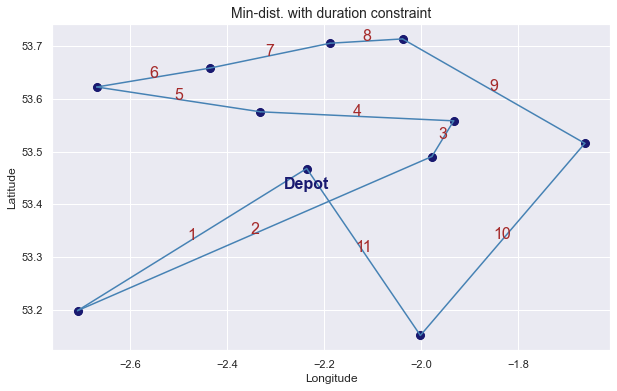

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='midnightblue')


# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'steelblue')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=16, color='brown')

plt.annotate('Depot', (dist['LNG'][0], dist['LAT'][0]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=16, color='midnightblue', weight='bold')

plt.title('Optimal Route Visualization', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Model3: Min-sum with epsilon constraint

## Model

In [ ]:
e = 0.2

# model
m3 = gp.Model("Min_sum_epsilon")
m3.params.NonConvex = 2    # non-convex constraints


# Variables
x = m3.addVars(n, n, vtype=GRB.BINARY, name='x')
z = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')
ta = m3.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = m3.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service
late = m3.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')
sum_late = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name='sum_late')
total_penalty = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')
total_duration = m3.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_duration')

da = m3.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='da')  # actural duration
di = m3.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='di')  # ideal duration


# Variables for penalty function
penalty_coeff = m3.addVars(p, name="penalty_coeff")
is_0_30 = m3.addVars(p, vtype=GRB.BINARY, name="is_0_30")
is_30_60 = m3.addVars(p, vtype=GRB.BINARY, name="is_30_60")
is_60_120 = m3.addVars(p, vtype=GRB.BINARY, name="is_60_120")
is_120_180 = m3.addVars(p, vtype=GRB.BINARY, name="is_120_180")
is_180_240 = m3.addVars(p, vtype=GRB.BINARY, name="is_180_240")
is_above_240 = m3.addVars(p, vtype=GRB.BINARY, name="is_above_240")


# Objective
m3.ModelSense = GRB.MINIMIZE
m3.setObjectiveN(z, 0, 1)
m3.setObjectiveN(total_dist, 1, 0)

# Constraints
m3.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))


# penalty function: piecewise linear
m3.addConstrs((late[i] >= 0 + sn - M * (1 - is_0_30[i]) for i in p), name="p_0_30")
m3.addConstrs((late[i] <= 30 + M * (1 - is_0_30[i]) for i in p), name="p_0_30")

m3.addConstrs((late[i] >= 30 + sn - M * (1 - is_30_60[i]) for i in p), name="p_30_60")
m3.addConstrs((late[i] <= 60 + M * (1 - is_30_60[i]) for i in p), name="p_30_60")

m3.addConstrs((late[i] >= 60 + sn - M * (1 - is_60_120[i]) for i in p), name="p_60_120")
m3.addConstrs((late[i] <= 120 + M * (1 - is_60_120[i]) for i in p), name="p_60_120")

m3.addConstrs((late[i] >= 120 + sn - M * (1 - is_120_180[i]) for i in p), name="p_120_180")
m3.addConstrs((late[i] <= 180 + M * (1 - is_120_180[i]) for i in p), name="p_120_180")

m3.addConstrs((late[i] >= 180 + sn - M * (1 - is_180_240[i]) for i in p), name="p_180_240")
m3.addConstrs((late[i] <= 240 + M * (1 - is_180_240[i]) for i in p), name="p_180_240")

m3.addConstrs((late[i] >= 240 + sn - M * (1 - is_above_240[i]) for i in p), name="p_over_240")

m3.addConstrs(is_0_30[i]+is_30_60[i]+is_60_120[i]+is_120_180[i]+is_180_240[i]+is_above_240[i] == 1 for i in p)

m3.addConstrs((penalty_coeff[i] == 0.1 * is_0_30[i] + 
                                   0.2 * is_30_60[i] + 
                                   0.4 * is_60_120[i] + 
                                   0.7 * is_120_180[i] +
                                   1.1 * is_180_240[i] +
                                   1.7 * is_above_240[i] for i in p), name="penalty_coeff")

m3.addConstr(total_penalty == gp.quicksum(penalty_coeff[i] * late[i] for i in p))

m3.addConstr((total_duration == ta[len(n)-1] - ts[0]))

m3.addConstr(sum_late == gp.quicksum(late[i] for i in p))
m3.addConstr((z >= sum_late + total_penalty), name='eq3')

m3.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq4')

m3.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq5')
m3.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq6')

m3.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq7')
m3.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq8')

m3.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq9')
m3.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq10')

m3.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq11')

m3.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')
m3.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')

m3.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq13')
m3.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq13')

m3.addConstrs((ts[j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq19')
m3.addConstrs((ts[j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq19')

m3.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq14')

m3.addConstrs((da[i] == ta[i + order_cnt] - ts[i] for i in p_plus), name='eq15')
m3.addConstrs((di[i] == time_matrix[i][i + order_cnt] + svc for i in p_plus), name='eq16')
m3.addConstrs((da[i] <= di[i] * (1 + e) for i in p_plus), name='eq17')

# solve
m3.optimize()

if m3.status == GRB.Status.OPTIMAL:
    print("Optimal solution found")
else:
    print("No optimal solution found.")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 410 rows, 265 columns and 1432 nonzeros
Model fingerprint: 0xa4b75b4b
Model has 1 quadratic constraint
Model has 10 general constraints
Variable types: 61 continuous, 204 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
-----------------------------------------------------------

## Results

### The optimal route

In [106]:
if m2.status == GRB.Status.OPTIMAL:

    route = {}
    for i in n:
        for j in n:
            if x[i, j].X > 0.5:
                if i not in route:
                    route[i] = []
                route[i].append(j)
    

    current_node = 0  
    best_route = [current_node]
    while current_node in route:
        next_node = route[current_node][0]  
        best_route.append(next_node)
        current_node = next_node
    
    print("The best route :", best_route)
else:
    print("No optimal solution found.")

The best route : [0, 4, 9, 5, 10, 2, 7, 3, 8, 1, 6, 11]


### Results for each point

In [108]:
di_values = [di[i].X for i in p_plus]
da_values = [da[i].X for i in p_plus]
p_time = [ts[i].X for i in p_plus]
d_time = [ta[i+order_cnt].X for i in p_plus]

e_result = pd.DataFrame({
    'ideal_duration':di_values,
    'actual_duration': da_values,
    'pickup': p_time,
    'delivery': d_time
})

In [109]:
e_result

,ideal_duration,actual_duration,pickup,delivery
0,45.492533,45.385933,954.135033,999.520967
1,34.228467,34.015267,636.064367,670.079633
2,56.578933,56.650000,840.000000,896.650000
3,47.322500,48.335200,420.000000,468.335200
4,67.238933,66.084100,514.609467,580.693567


In [110]:
ta_values = [ta[i].X for i in best_route]
ts_values = [ts[i].X for i in best_route]
late_values = [late[i].X for i in best_route]


result_df = pd.DataFrame({
    "Point": best_route,
    "ta": ta_values,
    "ts": ts_values,
    "late": late_values
})

In [111]:
result_df

,Point,ta,ts,late
0,0,0.000000,374.375200,0.000000
1,4,420.000000,420.000000,0.000001
2,9,468.335200,468.335200,0.000000
3,5,514.609467,514.609467,0.000000
4,10,580.693567,580.693567,0.000000
5,2,636.064367,636.064367,0.000000
6,7,670.079633,670.079633,0.000000
7,3,728.257567,840.000000,0.000000
8,8,896.650000,896.650000,0.000000
9,1,954.135033,954.135033,0.000000


In [102]:
print(f'Total distance: {total_dist.X}')

Total distance: 146.968


## Visualisation

### optimal result

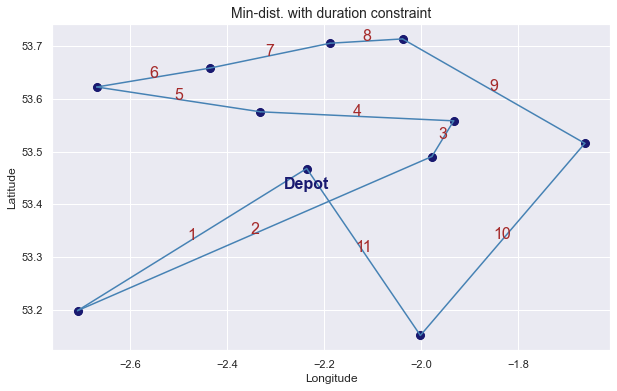

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='midnightblue')


# Plotting the route
for i in range(len(best_route) - 1):
    start_point = best_route[i]
    end_point = best_route[i + 1]
    plt.plot([dist['LNG'][start_point], dist['LNG'][end_point]], [dist['LAT'][start_point], dist['LAT'][end_point]], 'steelblue')
    mid_x = (dist['LNG'][start_point] + dist['LNG'][end_point]) / 2
    mid_y = (dist['LAT'][start_point] + dist['LAT'][end_point]) / 2
    plt.annotate(f'{i+1}', (mid_x, mid_y), textcoords="offset points", xytext=(0, 0), ha='center', fontsize=16, color='brown')

plt.annotate('Depot', (dist['LNG'][0], dist['LAT'][0]), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=16, color='midnightblue', weight='bold')

plt.title('Optimal Route Visualization', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Model4: min-distance

In [ ]:
# model
m4 = gp.Model("Min_dist")
m4.params.NonConvex = 2    # non-convex constraints

# Variables
x = m4.addVars(n, n, vtype=GRB.BINARY, name='x')
z = m4.addVar(lb=0, vtype=GRB.CONTINUOUS, name='z')
ta = m4.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ta')    # time arriving to the point
ts = m4.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='ts')    # time starting to service
late = m4.addVars(len(n), lb=0, vtype=GRB.CONTINUOUS, name='late')
sum_late = m4.addVar(lb=0, vtype=GRB.CONTINUOUS, name='sum_late')
total_penalty = m4.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_penalty')
total_dist = m4.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_dist')
total_duration = m4.addVar(lb=0, vtype=GRB.CONTINUOUS, name='total_duration')

da = m4.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='da')  # actural duration
di = m4.addVars(p_plus, lb=0, vtype=GRB.CONTINUOUS, name='di')  # ideal duration


# Variables for penalty function
penalty_coeff = m4.addVars(p, name="penalty_coeff")
is_0_30 = m4.addVars(p, vtype=GRB.BINARY, name="is_0_30")
is_30_60 = m4.addVars(p, vtype=GRB.BINARY, name="is_30_60")
is_60_120 = m4.addVars(p, vtype=GRB.BINARY, name="is_60_120")
is_120_180 = m4.addVars(p, vtype=GRB.BINARY, name="is_120_180")
is_180_240 = m4.addVars(p, vtype=GRB.BINARY, name="is_180_240")
is_above_240 = m4.addVars(p, vtype=GRB.BINARY, name="is_above_240")


# Objective
m4.setObjective(z, GRB.MINIMIZE)

# m4.ModelSense = GRB.MINIMIZE
# m4.setObjectiveN(z, 0, 1)
# m4.setObjectiveN(total_dist, 1, 0)

# Constraints

# penalty function: piecewise linear
m4.addConstrs((late[i] >= 0 + sn - M * (1 - is_0_30[i]) for i in p), name="p_0_30")
m4.addConstrs((late[i] <= 30 + M * (1 - is_0_30[i]) for i in p), name="p_0_30")

m4.addConstrs((late[i] >= 30 + sn - M * (1 - is_30_60[i]) for i in p), name="p_30_60")
m4.addConstrs((late[i] <= 60 + M * (1 - is_30_60[i]) for i in p), name="p_30_60")

m4.addConstrs((late[i] >= 60 + sn - M * (1 - is_60_120[i]) for i in p), name="p_60_120")
m4.addConstrs((late[i] <= 120 + M * (1 - is_60_120[i]) for i in p), name="p_60_120")

m4.addConstrs((late[i] >= 120 + sn - M * (1 - is_120_180[i]) for i in p), name="p_120_180")
m4.addConstrs((late[i] <= 180 + M * (1 - is_120_180[i]) for i in p), name="p_120_180")

m4.addConstrs((late[i] >= 180 + sn - M * (1 - is_180_240[i]) for i in p), name="p_180_240")
m4.addConstrs((late[i] <= 240 + M * (1 - is_180_240[i]) for i in p), name="p_180_240")

m4.addConstrs((late[i] >= 240 + sn - M * (1 - is_above_240[i]) for i in p), name="p_over_240")

m4.addConstrs(is_0_30[i]+is_30_60[i]+is_60_120[i]+is_120_180[i]+is_180_240[i]+is_above_240[i] == 1 for i in p)

m4.addConstrs((penalty_coeff[i] == 0.1 * is_0_30[i] + 
                                   0.2 * is_30_60[i] + 
                                   0.4 * is_60_120[i] + 
                                   0.7 * is_120_180[i] +
                                   1.1 * is_180_240[i] +
                                   1.7 * is_above_240[i] for i in p), name="penalty_coeff")

m4.addConstr(total_penalty == gp.quicksum(penalty_coeff[i] * late[i] for i in p))


m4.addConstr(sum_late == gp.quicksum(late[i] for i in p))

m4.addConstr((total_duration == ta[len(n)-1] - ts[0]))
m4.addConstrs((z >= total_dist + total_penalty for i in p_plus), name='eq3')

m4.addConstr(total_dist == gp.quicksum(x[i, j] * dist_matrix[i][j] for i in p for j in p if i != j))

m4.addConstrs((late[i] >= (ta[i] - tw['b'][i]) for i in p), name='eq4')

m4.addConstrs((gp.quicksum(x[i, j] for j in n_minus if i != j) == 1 for i in n_plus), name='eq5')
m4.addConstrs((gp.quicksum(x[i, j] for i in n_plus if i != j) == 1 for j in n_minus), name='eq6')

m4.addConstr((gp.quicksum(x[0, j] for j in p_plus) == 1), name='eq7')
m4.addConstr((gp.quicksum(x[i, len(n_plus)] for i in p_minus) == 1), name='eq8')

m4.addConstr((gp.quicksum(x[i, 0] for i in n_minus) == 0), name='eq9')
m4.addConstr((gp.quicksum(x[len(n_plus), i] for i in n_plus) == 0), name='eq10')

m4.addConstrs((ta[i] + svc + time_matrix[i][i + order_cnt] <= ta[i + order_cnt] for i in p_plus), name='eq11')

m4.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')
m4.addConstrs((ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j]) for i in n_plus for j in n_minus if i != 0 and i != j), name='eq12')

m4.addConstrs((ts[0] + time_matrix[0][j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq13')
m4.addConstrs((ts[0] + time_matrix[0][j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq13')

m4.addConstrs((ts[j] - ta[j] <= M * (1 - x[0, j]) for j in p_plus), name='eq19')
m4.addConstrs((ts[j] - ta[j] >= -M * (1 - x[0, j]) for j in p_plus), name='eq19')

m4.addConstrs((ts[i] == gp.max_([tw['a'][i], ta[i]]) for i in p), name='eq14')

m4.addConstrs((da[i] == ta[i + order_cnt] - ts[i] for i in p_plus), name='eq15')
m4.addConstrs((di[i] == time_matrix[i][i + order_cnt] + svc for i in p_plus), name='eq16')
# m4.addConstrs((da[i] <= di[i] * (1 + e) for i in p_plus), name='eq17')

# solve
m4.optimize()

if m4.status == GRB.Status.OPTIMAL:
    print("Optimal solution found")
else:
    print("No optimal solution found.")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 409 rows, 265 columns and 1434 nonzeros
Model fingerprint: 0xf5ab4237
Model has 1 quadratic constraint
Model has 10 general constraints
Variable types: 61 continuous, 204 integer (204 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
  GenCon const rng [4e+02, 8e+02]
Presolve removed 118 rows and 68 columns
Presolve time: 0.01s
Presolved: 332 rows, 207 columns, 1453 nonzeros
Presolved model has 10 bilinear constraint(s)
Variable types: 49 continuous, 158 integer (158 binary)

Root relaxation: objective 4.474518e+01, 130 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curr